<a href="https://colab.research.google.com/github/immischein/ML-bandgap/blob/main/Spacegroup_specific_endeavours.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Import
from mp_api.client import MPRester
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import json
from pymatgen.core.structure import Structure
import matplotlib.pyplot as plt
import seaborn as sns
from pymatgen.core.composition import Composition
from pymatgen.core.periodic_table import Element
import time

In [3]:
# You might need to reinstall the library manually, imports ans pip install:
!pip install mp_api
!pip install pymatgen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.6/55.6 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.1/217.1 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.6/122.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 332.3/332.3 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [5]:
with MPRester("VlQ1oWGAXlhWiKRkPOk5q1cP8dNS6mIu") as mpr:
  #Please edit features you want to filter from inside the search() command. for example:
  example_docs = mpr.materials.summary.search(spacegroup_number = 221, num_sites = 5)


Retrieving SummaryDoc documents:   0%|          | 0/1458 [00:00<?, ?it/s]

In [6]:
with MPRester("VlQ1oWGAXlhWiKRkPOk5q1cP8dNS6mIu") as mpr:
  #Please edit features you want to filter from inside the search() command. for example:
  example_docs2 = mpr.materials.summary.search(spacegroup_number = 221, num_sites = 5,band_gap=(.001, None))


Retrieving SummaryDoc documents:   0%|          | 0/225 [00:00<?, ?it/s]

In [12]:

def get_outermost_p_orbitals(atomic_number):
    el = Element.from_Z(atomic_number)
    config = el.full_electronic_structure  # [(orbital_label, l, electrons)]

    p_orbs = [(orb, e) for orb, l, e in config if l == 'p']
    highest_p = max(p_orbs, key=lambda x: x[0])  # x[0]

    return highest_p[1]


def get_outermost_s_orbitals(atomic_number):
    el = Element.from_Z(atomic_number)
    config = el.full_electronic_structure  # [(orbital_label, l, electrons)]

    s_orbs = [(orb, e) for orb, l, e in config if l == 's']
    highest_s = max(s_orbs, key=lambda x: x[0])  # x[0]

    return highest_s[1]

In [7]:
material_positions_frac = []
material_positions = []
bandgaps = []
elements_f_l = []
for m in example_docs:
  single_material_positions = []
  single_material_frac_positions = []
  elements_l = []
  for site in m.structure.sites:
    frac_coords = site.frac_coords
    single_material_frac_positions.append(site.frac_coords)
    single_material_positions.append(site.coords)
    elements_l.append(site.specie.number)

  material_positions_frac.append(single_material_frac_positions)
  material_positions.append(single_material_positions)
  bandgaps.append(m.band_gap)
  elements_f_l.append(elements_l)

In [8]:
all_material = []

for group in material_positions_frac:
  unique_positions = []
  for coord in group:
      # Round to 4 decimal places to eliminate noise
      rounded = tuple(np.round(coord % 1, 4))  # mod 1 ensures coords are in [0, 1)
      unique_positions.append(rounded)
  all_material.append(unique_positions.copy())

In [9]:
df_temporary = pd.DataFrame(list(zip(material_positions_frac, material_positions, bandgaps, elements_f_l)),
               columns =['all_material', 'material_positions', 'bandgaps', 'elements'])

In [13]:
vdw_values = []
s_numbers= []
atomic_radius_calculated_L = []
atomic_orbitals_L = []
molar_volume_L = []
for values in df_temporary['elements']:

  vdw_values.append([Element.from_Z(number).van_der_waals_radius for number in values])
  atomic_radius_calculated_L.append([Element.from_Z(number).atomic_radius_calculated for number in values])
  atomic_orbitals_L.append([Element.from_Z(number).atomic_orbitals for number in values])
  molar_volume_L.append([Element.from_Z(number).molar_volume for number in values])
  # electron_p_number = [get_outermost_p_orbitals(number) for number in values]
  electron_s_number = [get_outermost_s_orbitals(number) for number in values]
  s_numbers.append(electron_s_number)



<ipython-input-13-fcd198d95712>:9: UserWarning: No data available for atomic_radius_calculated for Ac
  atomic_radius_calculated_L.append([Element.from_Z(number).atomic_radius_calculated for number in values])
<ipython-input-13-fcd198d95712>:9: UserWarning: No data available for atomic_radius_calculated for Ce
  atomic_radius_calculated_L.append([Element.from_Z(number).atomic_radius_calculated for number in values])
<ipython-input-13-fcd198d95712>:9: UserWarning: No data available for atomic_radius_calculated for Np
  atomic_radius_calculated_L.append([Element.from_Z(number).atomic_radius_calculated for number in values])
<ipython-input-13-fcd198d95712>:10: UserWarning: No data available for atomic_orbitals for Np
  atomic_orbitals_L.append([Element.from_Z(number).atomic_orbitals for number in values])
<ipython-input-13-fcd198d95712>:9: UserWarning: No data available for atomic_radius_calculated for Pa
  atomic_radius_calculated_L.append([Element.from_Z(number).atomic_radius_calculated

In [21]:
df_temporary_2 = pd.DataFrame(list(zip(material_positions_frac, material_positions, bandgaps, elements_f_l, vdw_values, s_numbers, atomic_radius_calculated_L, atomic_orbitals_L, molar_volume_L)),
               columns =['all_material', 'material_positions', 'bandgaps', 'elements', ' vdw_values', 's_numbers', 'atomic_radius_calculated_L', 'atomic_orbitals_L', 'molar_volume_L' ])
df_temporary_2

,all_material,material_positions,bandgaps,elements,vdw_values,s_numbers,atomic_radius_calculated_L,atomic_orbitals_L,molar_volume_L
0,"[[-0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.5, 0.5,...","[[0.0, 0.0, 0.0], [1.9293169350000001, 1.92931...",4.1024,"[89, 13, 8, 8, 8]","[2.47 ang, 1.84 ang, 1.52 ang, 1.52 ang, 1.52 ...","[2, 2, 2, 2, 2]","[None, 1.18 ang, 0.48 ang, 0.48 ang, 0.48 ang]","[{'1s': -3443.110367, '2p': -572.7627, '2s': -...","[22.55 cm^3, 10.0 cm^3, 17.36 cm^3, 17.36 cm^3..."
1,"[[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.5, 0.5, ...","[[0.0, 0.0, 0.0], [1.860834, 1.860834, 1.86083...",0.8071,"[89, 5, 8, 8, 8]","[2.47 ang, 1.92 ang, 1.52 ang, 1.52 ang, 1.52 ...","[2, 2, 2, 2, 2]","[None, 0.87 ang, 0.48 ang, 0.48 ang, 0.48 ang]","[{'1s': -3443.110367, '2p': -572.7627, '2s': -...","[22.55 cm^3, 4.39 cm^3, 17.36 cm^3, 17.36 cm^3..."
2,"[[-0.0, -0.0, -0.0], [0.5, 0.5, 0.5], [0.5, 0....","[[0.0, 0.0, 0.0], [1.97214345, 1.97215113, 1.9...",2.0031,"[89, 24, 8, 8, 8]","[2.47 ang, 2.06 ang, 1.52 ang, 1.52 ang, 1.52 ...","[2, 1, 2, 2, 2]","[None, 1.66 ang, 0.48 ang, 0.48 ang, 0.48 ang]","[{'1s': -3443.110367, '2p': -572.7627, '2s': -...","[22.55 cm^3, 7.23 cm^3, 17.36 cm^3, 17.36 cm^3..."
3,"[[0.0, 0.0, 0.0], [0.499998, 0.499998, 0.49999...","[[0.0, 0.0, 0.0], [1.9566577983375, 1.95665779...",0.0000,"[89, 29, 8, 8, 8]","[2.47 ang, 1.96 ang, 1.52 ang, 1.52 ang, 1.52 ...","[2, 1, 2, 2, 2]","[None, 1.45 ang, 0.48 ang, 0.48 ang, 0.48 ang]","[{'1s': -3443.110367, '2p': -572.7627, '2s': -...","[22.55 cm^3, 7.11 cm^3, 17.36 cm^3, 17.36 cm^3..."
4,"[[-0.0, 0.0, 0.0], [0.499998999999999, 0.49999...","[[0.0, 0.0, 0.0], [1.9767808564303762, 1.97677...",0.9888,"[89, 26, 8, 8, 8]","[2.47 ang, 2.04 ang, 1.52 ang, 1.52 ang, 1.52 ...","[2, 2, 2, 2, 2]","[None, 1.56 ang, 0.48 ang, 0.48 ang, 0.48 ang]","[{'1s': -3443.110367, '2p': -572.7627, '2s': -...","[22.55 cm^3, 7.09 cm^3, 17.36 cm^3, 17.36 cm^3..."
...,...,...,...,...,...,...,...,...,...
1453,"[[0.0, 0.0, 0.0], [-0.0, 0.5, 0.5], [0.5, -0.0...","[[0.0, 0.0, 0.0], [0.0, 2.03775825, 2.03775825...",0.0000,"[40, 44, 44, 44, 6]","[2.23 ang, 2.13 ang, 2.13 ang, 2.13 ang, 1.7 ang]","[2, 1, 1, 1, 2]","[2.06 ang, 1.78 ang, 1.78 ang, 1.78 ang, 0.67 ...","[{'1s': -639.292236, '2p': -80.010043, '2s': -...","[14.02 cm^3, 8.17 cm^3, 8.17 cm^3, 8.17 cm^3, ..."
1454,"[[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.5, 0.5, ...","[[0.0, 0.0, 0.0], [1.8317364999999994, 1.83173...",0.0000,"[40, 14, 8, 8, 8]","[2.23 ang, 2.1 ang, 1.52 ang, 1.52 ang, 1.52 ang]","[2, 2, 2, 2, 2]","[2.06 ang, 1.11 ang, 0.48 ang, 0.48 ang, 0.48 ...","[{'1s': -639.292236, '2p': -80.010043, '2s': -...","[14.02 cm^3, 12.06 cm^3, 17.36 cm^3, 17.36 cm^..."
1455,"[[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.5, 0.5, ...","[[0.0, 0.0, 0.0], [1.9295495, 1.9295495, 1.929...",0.0000,"[40, 22, 8, 8, 8]","[2.23 ang, 2.11 ang, 1.52 ang, 1.52 ang, 1.52 ...","[2, 2, 2, 2, 2]","[2.06 ang, 1.76 ang, 0.48 ang, 0.48 ang, 0.48 ...","[{'1s': -639.292236, '2p': -80.010043, '2s': -...","[14.02 cm^3, 10.64 cm^3, 17.36 cm^3, 17.36 cm^..."
1456,"[[0.5, 0.5, 0.5], [0.0, 0.0, 0.0], [0.5, 0.5, ...","[[2.106323, 2.106323, 2.106323], [0.0, 0.0, 0....",0.0000,"[40, 81, 8, 8, 8]","[2.23 ang, 1.96 ang, 1.52 ang, 1.52 ang, 1.52 ...","[2, 2, 2, 2, 2]","[2.06 ang, 1.56 ang, 0.48 ang, 0.48 ang, 0.48 ...","[{'1s': -639.292236, '2p': -80.010043, '2s': -...","[14.02 cm^3, 17.22 cm^3, 17.36 cm^3, 17.36 cm^..."


In [19]:
import numpy as np

def find_wyckoff_1b_3c_indices(coords):
    # Normalize and round for matching
    rounded_coords = [tuple(np.round(np.array(c) % 1, 6)) for c in coords]

    wyckoff_1b = (0.5, 0.5, 0.5)
    wyckoff_3c_list = [
        (0.5, 0.5, 0.0),
        (0.5, 0.0, 0.5),
        (0.0, 0.5, 0.5),
    ]

    # Find index of 1b
    try:
        i1b = rounded_coords.index(wyckoff_1b)
    except ValueError:
        i1b = None

    # Find index of any 3c
    i3c = None
    for w3c in wyckoff_3c_list:
        if w3c in rounded_coords:
            i3c = rounded_coords.index(w3c)
            break

    both_found = i1b is not None and i3c is not None

    return i1b, i3c, both_found

In [31]:
df_temporary_2

,all_material,material_positions,bandgaps,elements,vdw_values,s_numbers,atomic_radius_calculated_L,atomic_orbitals_L,molar_volume_L
0,"[[-0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.5, 0.5,...","[[0.0, 0.0, 0.0], [1.9293169350000001, 1.92931...",4.1024,"[89, 13, 8, 8, 8]","[2.47 ang, 1.84 ang, 1.52 ang, 1.52 ang, 1.52 ...","[2, 2, 2, 2, 2]","[None, 1.18 ang, 0.48 ang, 0.48 ang, 0.48 ang]","[{'1s': -3443.110367, '2p': -572.7627, '2s': -...","[22.55 cm^3, 10.0 cm^3, 17.36 cm^3, 17.36 cm^3..."
1,"[[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.5, 0.5, ...","[[0.0, 0.0, 0.0], [1.860834, 1.860834, 1.86083...",0.8071,"[89, 5, 8, 8, 8]","[2.47 ang, 1.92 ang, 1.52 ang, 1.52 ang, 1.52 ...","[2, 2, 2, 2, 2]","[None, 0.87 ang, 0.48 ang, 0.48 ang, 0.48 ang]","[{'1s': -3443.110367, '2p': -572.7627, '2s': -...","[22.55 cm^3, 4.39 cm^3, 17.36 cm^3, 17.36 cm^3..."
2,"[[-0.0, -0.0, -0.0], [0.5, 0.5, 0.5], [0.5, 0....","[[0.0, 0.0, 0.0], [1.97214345, 1.97215113, 1.9...",2.0031,"[89, 24, 8, 8, 8]","[2.47 ang, 2.06 ang, 1.52 ang, 1.52 ang, 1.52 ...","[2, 1, 2, 2, 2]","[None, 1.66 ang, 0.48 ang, 0.48 ang, 0.48 ang]","[{'1s': -3443.110367, '2p': -572.7627, '2s': -...","[22.55 cm^3, 7.23 cm^3, 17.36 cm^3, 17.36 cm^3..."
3,"[[0.0, 0.0, 0.0], [0.499998, 0.499998, 0.49999...","[[0.0, 0.0, 0.0], [1.9566577983375, 1.95665779...",0.0000,"[89, 29, 8, 8, 8]","[2.47 ang, 1.96 ang, 1.52 ang, 1.52 ang, 1.52 ...","[2, 1, 2, 2, 2]","[None, 1.45 ang, 0.48 ang, 0.48 ang, 0.48 ang]","[{'1s': -3443.110367, '2p': -572.7627, '2s': -...","[22.55 cm^3, 7.11 cm^3, 17.36 cm^3, 17.36 cm^3..."
4,"[[-0.0, 0.0, 0.0], [0.499998999999999, 0.49999...","[[0.0, 0.0, 0.0], [1.9767808564303762, 1.97677...",0.9888,"[89, 26, 8, 8, 8]","[2.47 ang, 2.04 ang, 1.52 ang, 1.52 ang, 1.52 ...","[2, 2, 2, 2, 2]","[None, 1.56 ang, 0.48 ang, 0.48 ang, 0.48 ang]","[{'1s': -3443.110367, '2p': -572.7627, '2s': -...","[22.55 cm^3, 7.09 cm^3, 17.36 cm^3, 17.36 cm^3..."
...,...,...,...,...,...,...,...,...,...
1453,"[[0.0, 0.0, 0.0], [-0.0, 0.5, 0.5], [0.5, -0.0...","[[0.0, 0.0, 0.0], [0.0, 2.03775825, 2.03775825...",0.0000,"[40, 44, 44, 44, 6]","[2.23 ang, 2.13 ang, 2.13 ang, 2.13 ang, 1.7 ang]","[2, 1, 1, 1, 2]","[2.06 ang, 1.78 ang, 1.78 ang, 1.78 ang, 0.67 ...","[{'1s': -639.292236, '2p': -80.010043, '2s': -...","[14.02 cm^3, 8.17 cm^3, 8.17 cm^3, 8.17 cm^3, ..."
1454,"[[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.5, 0.5, ...","[[0.0, 0.0, 0.0], [1.8317364999999994, 1.83173...",0.0000,"[40, 14, 8, 8, 8]","[2.23 ang, 2.1 ang, 1.52 ang, 1.52 ang, 1.52 ang]","[2, 2, 2, 2, 2]","[2.06 ang, 1.11 ang, 0.48 ang, 0.48 ang, 0.48 ...","[{'1s': -639.292236, '2p': -80.010043, '2s': -...","[14.02 cm^3, 12.06 cm^3, 17.36 cm^3, 17.36 cm^..."
1455,"[[0.0, 0.0, 0.0], [0.5, 0.5, 0.5], [0.5, 0.5, ...","[[0.0, 0.0, 0.0], [1.9295495, 1.9295495, 1.929...",0.0000,"[40, 22, 8, 8, 8]","[2.23 ang, 2.11 ang, 1.52 ang, 1.52 ang, 1.52 ...","[2, 2, 2, 2, 2]","[2.06 ang, 1.76 ang, 0.48 ang, 0.48 ang, 0.48 ...","[{'1s': -639.292236, '2p': -80.010043, '2s': -...","[14.02 cm^3, 10.64 cm^3, 17.36 cm^3, 17.36 cm^..."
1456,"[[0.5, 0.5, 0.5], [0.0, 0.0, 0.0], [0.5, 0.5, ...","[[2.106323, 2.106323, 2.106323], [0.0, 0.0, 0....",0.0000,"[40, 81, 8, 8, 8]","[2.23 ang, 1.96 ang, 1.52 ang, 1.52 ang, 1.52 ...","[2, 2, 2, 2, 2]","[2.06 ang, 1.56 ang, 0.48 ang, 0.48 ang, 0.48 ...","[{'1s': -639.292236, '2p': -80.010043, '2s': -...","[14.02 cm^3, 17.22 cm^3, 17.36 cm^3, 17.36 cm^..."


In [77]:
distances = []
band_gaps = []
elements_1b = []
elements_3c = []
electrons_1b_s = []
electrons_3c_s = []

atomic_radiuss_1b = []
atomic_radiuss_3c = []

atomic_orbitalss_1b_largest_1 = []
atomic_orbitalss_1b_largest_2 = []
atomic_orbitalss_1b_largest_3 = []

atomic_orbitalss_3c_largest_1 = []
atomic_orbitalss_3c_largest_2 = []
atomic_orbitalss_3c_largest_3 = []


molar_volumess_1b = []
molar_volumess_3c = []
van_der_waals_radius_sum = []
vanderwaals_1b = []
vanderwaals_3c = []




for data in df_temporary_2.values:
  pos1b, pos3c, both = find_wyckoff_1b_3c_indices(data[0])
  if both and data[7][pos1b] != None:
    distance = np.linalg.norm(data[1][pos1b] - data[1][pos3c])
    distances.append(distance)
    band_gaps.append(data[2])

    van_der_waals_radius_sum.append(data[4][pos1b] + data[4][pos3c])

    electrons_1b_s.append(data[5][pos1b])
    electrons_3c_s.append(data[5][pos3c])

    atomic_radiuss_1b.append(data[6][pos1b])
    atomic_radiuss_3c.append(data[6][pos3c])

    molar_volumess_1b.append(data[8][pos1b])
    molar_volumess_3c.append(data[8][pos3c])

    vanderwaals_1b.append(data[4][pos1b])
    vanderwaals_3c.append(data[4][pos3c])
    elements_1b.append(data[3][pos1b])
    elements_3c.append(data[3][pos3c])

    atomic_orbitalss_1b_largest_1.append(list(data[7][pos1b].values())[-1])
    # atomic_orbitalss_1b_largest_2.append(list(data[7][pos1b].values())[-2])
    # atomic_orbitalss_1b_largest_3.append(list(data[7][pos1b].values())[-3])

    atomic_orbitalss_3c_largest_1.append(list(data[7][pos3c].values())[-1])
    # atomic_orbitalss_3c_largest_2.append(list(data[7][pos3c].values())[-2])
    # atomic_orbitalss_3c_largest_3.append(list(data[7][pos3c].values())[-3])

IndexError: list index out of range

In [76]:
van_der_waals_radius_sum = np.array(van_der_waals_radius_sum)
distances = np.array(distances)

overlap = van_der_waals_radius_sum - distances

In [78]:
df_final = pd.DataFrame(list(zip(bandgaps, vanderwaals_1b,vanderwaals_3c, van_der_waals_radius_sum, distances, overlap, elements_1b,elements_3c,  electrons_1b_s, electrons_3c_s, atomic_radiuss_1b, atomic_radiuss_3c, atomic_orbitalss_1b_largest_1, atomic_orbitalss_3c_largest_1, molar_volumess_1b, molar_volumess_3c)),
                  columns =['bandgaps','vanderwaals_1b','vanderwaals_3c', 'van_der_waals_radius_sum', 'distances', 'overlap','elements_1b','elements_3c', 'electrons_1b_s', 'electrons_3c_s', 'atomic_radiuss_1b', 'atomic_radiuss_3c', 'atomic_orbitalss_1b_largest_1', 'atomic_orbitalss_3c_largest_1', 'molar_volumess_1b', 'molar_volumess_3c'])

In [64]:
list(df_final['atomic_orbitalss_1b'][1].values())

[-6.564347, -0.136603, -0.344701]

In [79]:
df_final

,bandgaps,vanderwaals_1b,vanderwaals_3c,van_der_waals_radius_sum,distances,overlap,elements_1b,elements_3c,electrons_1b_s,electrons_3c_s,atomic_radiuss_1b,atomic_radiuss_3c,atomic_orbitalss_1b_largest_1,atomic_orbitalss_3c_largest_1,molar_volumess_1b,molar_volumess_3c
0,4.1024,1.84,1.52,3.36,1.929317,1.430683,13,8,2,2,1.18,0.48,-0.286883,-0.871362,10.00,17.36
1,0.8071,1.92,1.52,3.44,1.860834,1.579166,5,8,2,2,0.87,0.48,-0.344701,-0.871362,4.39,17.36
2,2.0031,2.06,1.52,3.58,1.972136,1.607864,24,8,1,2,1.66,0.48,-0.150445,-0.871362,7.23,17.36
3,0.0000,1.87,1.52,3.39,1.973131,1.416869,31,8,2,2,1.36,0.48,-0.328019,-0.871362,11.80,17.36
4,0.9888,1.73,1.52,3.25,2.008131,1.241869,12,8,2,2,1.45,0.48,-0.175427,-0.871362,14.00,17.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.0000,2.35,1.52,3.87,2.218639,1.651361,63,8,2,2,2.31,0.48,-0.129426,-0.871362,28.97,17.36
76,0.0000,2.11,1.52,3.63,1.990194,1.639806,32,8,2,2,1.25,0.48,-0.426523,-0.871362,13.63,17.36
77,0.0000,1.93,1.52,3.45,2.142898,1.307103,49,8,2,2,1.56,0.48,-0.290497,-0.871362,15.76,17.36
78,0.2992,1.82,1.47,3.29,1.994291,1.295709,3,9,1,2,1.67,0.42,-0.105540,-1.086859,13.02,11.20


In [80]:
df_final.corr()

,bandgaps,vanderwaals_1b,vanderwaals_3c,van_der_waals_radius_sum,distances,overlap,elements_1b,elements_3c,electrons_1b_s,electrons_3c_s,atomic_radiuss_1b,atomic_radiuss_3c,atomic_orbitalss_1b_largest_1,atomic_orbitalss_3c_largest_1,molar_volumess_1b,molar_volumess_3c
bandgaps,1.000000,0.032977,-0.179452,-0.182278,-0.183037,0.052332,-0.097360,-0.190059,-0.035873,0.064802,0.087737,-0.182932,0.141321,-0.175696,-0.202265,-0.189341
vanderwaals_1b,0.032977,1.000000,-0.395588,-0.036824,-0.133343,0.362287,0.663180,-0.417979,-0.134222,0.149456,0.837860,-0.414038,0.274894,-0.443208,0.243079,-0.278083
vanderwaals_3c,-0.179452,-0.395588,1.000000,0.932372,0.932770,-0.254977,0.147315,0.973739,0.277150,0.059852,-0.459763,0.995260,-0.355257,0.940921,0.485018,0.919412
van_der_waals_radius_sum,-0.182278,-0.036824,0.932372,1.000000,0.962443,-0.134837,0.421323,0.894985,0.248731,0.123951,-0.170471,0.919952,-0.278348,0.849346,0.623415,0.890937
distances,-0.183037,-0.133343,0.932770,0.962443,1.000000,-0.398779,0.390107,0.897345,0.198374,0.050739,-0.162444,0.930319,-0.263955,0.871264,0.672571,0.919321
overlap,0.052332,0.362287,-0.254977,-0.134837,-0.398779,1.000000,-0.000632,-0.251973,0.116159,0.233506,0.017057,-0.287984,0.023157,-0.310943,-0.348924,-0.345857
elements_1b,-0.097360,0.663180,0.147315,0.421323,0.390107,-0.000632,1.000000,0.111663,-0.046913,0.165969,0.613493,0.129750,0.037563,0.079307,0.565876,0.217817
elements_3c,-0.190059,-0.417979,0.973739,0.894985,0.897345,-0.251973,0.111663,1.000000,0.255846,-0.129830,-0.476533,0.978815,-0.350805,0.951642,0.448423,0.846816
electrons_1b_s,-0.035873,-0.134222,0.277150,0.248731,0.198374,0.116159,-0.046913,0.255846,1.000000,0.171726,-0.313286,0.248272,-0.244589,0.204059,0.145708,0.245865
electrons_3c_s,0.064802,0.149456,0.059852,0.123951,0.050739,0.233506,0.165969,-0.129830,0.171726,1.000000,0.080870,-0.012652,0.003503,-0.205759,0.048948,0.256896


In [81]:
df_final.corr(method='spearman')

,bandgaps,vanderwaals_1b,vanderwaals_3c,van_der_waals_radius_sum,distances,overlap,elements_1b,elements_3c,electrons_1b_s,electrons_3c_s,atomic_radiuss_1b,atomic_radiuss_3c,atomic_orbitalss_1b_largest_1,atomic_orbitalss_3c_largest_1,molar_volumess_1b,molar_volumess_3c
bandgaps,1.000000,-0.026703,-0.247326,-0.279796,-0.201587,-0.011933,-0.157699,-0.198494,-0.099908,0.086495,0.127944,-0.265534,0.294175,-0.265534,-0.187714,-0.259992
vanderwaals_1b,-0.026703,1.000000,-0.349896,0.106798,0.013945,0.442849,0.697762,-0.400826,-0.135374,0.209913,0.759279,-0.385991,0.503540,-0.385844,0.176344,-0.163516
vanderwaals_3c,-0.247326,-0.349896,1.000000,0.868873,0.784712,-0.359504,0.202005,0.954531,0.334644,0.056929,-0.482561,0.965531,-0.806063,0.965501,0.500307,0.847397
van_der_waals_radius_sum,-0.279796,0.106798,0.868873,1.000000,0.869797,-0.158182,0.531664,0.828927,0.207249,0.055655,-0.105021,0.838337,-0.588533,0.838418,0.653001,0.750375
distances,-0.201587,0.013945,0.784712,0.869797,1.000000,-0.553610,0.546094,0.777325,0.112068,-0.029917,0.030847,0.798817,-0.491917,0.799058,0.823180,0.753024
overlap,-0.011933,0.442849,-0.359504,-0.158182,-0.553610,1.000000,-0.061058,-0.377034,-0.022030,0.103997,0.087833,-0.419347,0.269125,-0.421221,-0.456973,-0.427831
elements_1b,-0.157699,0.697762,0.202005,0.531664,0.546094,-0.061058,1.000000,0.128914,-0.010555,0.194101,0.635830,0.154628,0.079614,0.155325,0.571792,0.299549
elements_3c,-0.198494,-0.400826,0.954531,0.828927,0.777325,-0.377034,0.128914,1.000000,0.244968,-0.034157,-0.472426,0.920062,-0.772065,0.919176,0.481297,0.758598
electrons_1b_s,-0.099908,-0.135374,0.334644,0.207249,0.112068,-0.022030,-0.010555,0.244968,1.000000,0.171726,-0.367535,0.244968,-0.446208,0.244968,0.133383,0.273402
electrons_3c_s,0.086495,0.209913,0.056929,0.055655,-0.029917,0.103997,0.194101,-0.034157,0.171726,1.000000,0.065654,-0.095966,0.028544,-0.095966,0.034253,0.352960


In [82]:
df_final.corr(method='kendall')

,bandgaps,vanderwaals_1b,vanderwaals_3c,van_der_waals_radius_sum,distances,overlap,elements_1b,elements_3c,electrons_1b_s,electrons_3c_s,atomic_radiuss_1b,atomic_radiuss_3c,atomic_orbitalss_1b_largest_1,atomic_orbitalss_3c_largest_1,molar_volumess_1b,molar_volumess_3c
bandgaps,1.000000,-0.019542,-0.229109,-0.223320,-0.159957,-0.012127,-0.124349,-0.185617,-0.096212,0.083296,0.101449,-0.246195,0.232786,-0.246195,-0.145565,-0.241535
vanderwaals_1b,-0.019542,1.000000,-0.280635,0.224175,0.047055,0.289142,0.488497,-0.327772,-0.113785,0.176437,0.605242,-0.317297,0.385168,-0.316424,0.112934,-0.120896
vanderwaals_3c,-0.229109,-0.280635,1.000000,0.746535,0.625218,-0.276220,0.168964,0.914139,0.323865,0.055095,-0.390808,0.946193,-0.671949,0.945049,0.393092,0.777905
van_der_waals_radius_sum,-0.223320,0.224175,0.746535,1.000000,0.730092,-0.119798,0.393145,0.684866,0.173446,0.046578,0.000000,0.705712,-0.338441,0.706581,0.473554,0.598878
distances,-0.159957,0.047055,0.625218,0.730092,1.000000,-0.401899,0.403700,0.614153,0.092073,-0.024579,0.080483,0.643094,-0.222842,0.643945,0.634293,0.587765
overlap,-0.012127,0.289142,-0.276220,-0.119798,-0.401899,1.000000,-0.042631,-0.288988,-0.018100,0.085442,0.083069,-0.316227,0.186025,-0.317078,-0.299061,-0.366449
elements_1b,-0.124349,0.488497,0.168964,0.393145,0.403700,-0.042631,1.000000,0.104680,-0.008834,0.162452,0.415306,0.129004,0.050758,0.129872,0.437706,0.241068
elements_3c,-0.185617,-0.327772,0.914139,0.684866,0.614153,-0.288988,0.104680,1.000000,0.237078,-0.033057,-0.380375,0.860332,-0.625038,0.859187,0.389617,0.692044
electrons_1b_s,-0.096212,-0.113785,0.323865,0.173446,0.092073,-0.018100,-0.008834,0.237078,1.000000,0.171726,-0.307850,0.237078,-0.373452,0.237078,0.111634,0.264596
electrons_3c_s,0.083296,0.176437,0.055095,0.046578,-0.024579,0.085442,0.162452,-0.033057,0.171726,1.000000,0.054992,-0.092875,0.023890,-0.092875,0.028668,0.341592


In [85]:
from sklearn.feature_selection import mutual_info_regression

mi = mutual_info_regression(X=df_final.drop(columns=["bandgaps"]), y=df_final["bandgaps"])
mi

array([0.04637643, 0.        , 0.04607537, 0.        , 0.01528147,
       0.04105928, 0.        , 0.        , 0.03036863, 0.        ,
       0.03092939, 0.        , 0.        , 0.        , 0.        ])

In [124]:
import pandas as pd
import itertools
import numpy as np
from sklearn.feature_selection import mutual_info_regression

def generate_power_interactions(df, target_col, method="pearson", max_features=4, max_power=4):
    results = []
    features = [col for col in df.columns if col != target_col]
    target = df[target_col]

    for feature_combo in itertools.combinations(features, r=3):  # only 3-feature combos
        # All power combinations: (1,1,1) to (3,3,3)
        for powers in itertools.product(range(1, max_power + 1), repeat=3):
            try:
                term = (df[feature_combo[0]] ** powers[0]) * \
                       (df[feature_combo[1]] ** powers[1]) * \
                       (df[feature_combo[2]] ** powers[2])

                name = f"{feature_combo[0]}^{powers[0]}*{feature_combo[1]}^{powers[1]}*{feature_combo[2]}^{powers[2]}"

                # Correlation or mutual info
                if method == "pearson":
                    score = term.corr(target)
                elif method == "spearman":
                    score = term.corr(target, method="spearman")
                elif method == "mutual_info":
                    score = mutual_info_regression(term.to_frame(), target)[0]
                else:
                    raise ValueError("Unknown method")

                results.append((name, score))
            except Exception as e:
                results.append((name, f"Error: {e}"))

    # Sort results numerically by abs(score), ignore errors
    results = [r for r in results if isinstance(r[1], (float, int, np.number))]
    results.sort(key=lambda x: abs(x[1]), reverse=True)
    return results

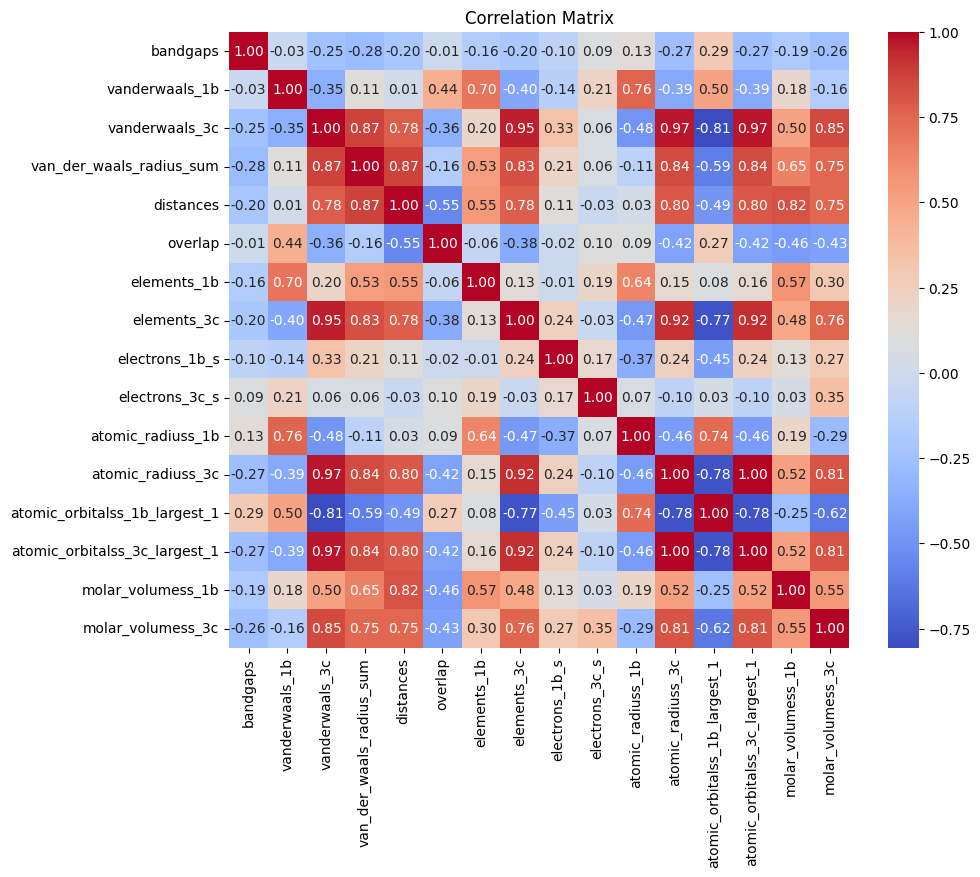

In [162]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_final.corr(method = 'spearman', numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [148]:
mutualinfo = generate_power_interactions(df_final, "bandgaps", method="spearman",max_features= 3, max_power = 3)
mutualinfo2 = generate_power_interactions(df_final, "bandgaps", method="pearson",max_features= 3, max_power = 3)
mutualinfo3 = generate_power_interactions(df_final, "bandgaps", method="mutual_info",max_features= 3, max_power = 3)


In [149]:
append_features = []
append_values =[]
for (name, number) in mutualinfo:

  append_features.append(name)
  append_values.append(number)

append_features2 = []
append_values2 =[]
for (name, number) in mutualinfo2:

  append_features2.append(name)
  append_values2.append(number)

append_features3 = []
append_values3 =[]
for (name, number) in mutualinfo3:

  append_features3.append(name)
  append_values3.append(number)





In [150]:
df_new_mi1 = pd.DataFrame(list(zip(append_features, append_values)), columns =['features', 'values'])
df_new_mi2 = pd.DataFrame(list(zip(append_features2, append_values2)), columns =['features', 'values'])
df_new_mi3 = pd.DataFrame(list(zip(append_features3, append_values3)), columns =['features', 'values'])

df_new_mi1



,features,values
0,overlap^3*elements_1b^1*atomic_orbitalss_1b_la...,-0.354565
1,overlap^1*elements_1b^1*atomic_orbitalss_1b_la...,-0.350989
2,overlap^1*elements_1b^2*atomic_orbitalss_1b_la...,0.350478
3,overlap^3*elements_1b^1*atomic_orbitalss_1b_la...,0.350186
4,overlap^2*elements_1b^2*atomic_orbitalss_1b_la...,0.348726
...,...,...
12280,vanderwaals_1b^3*van_der_waals_radius_sum^3*at...,-0.000292
12281,overlap^1*atomic_radiuss_1b^3*molar_volumess_3c^1,0.000255
12282,elements_1b^3*electrons_1b_s^2*atomic_orbitals...,0.000219
12283,elements_1b^3*elements_3c^1*atomic_orbitalss_3...,-0.000146


In [152]:
df_new_mi3

,features,values
0,electrons_3c_s^2*atomic_radiuss_3c^2*molar_vol...,0.281961
1,electrons_3c_s^3*atomic_radiuss_3c^2*molar_vol...,0.240199
2,elements_3c^3*electrons_3c_s^2*atomic_orbitals...,0.238901
3,elements_3c^2*electrons_1b_s^2*molar_volumess_...,0.234682
4,vanderwaals_3c^2*atomic_radiuss_3c^1*molar_vol...,0.215398
...,...,...
12280,atomic_orbitalss_3c_largest_1^3*molar_volumess...,0.000000
12281,atomic_orbitalss_3c_largest_1^3*molar_volumess...,0.000000
12282,atomic_orbitalss_3c_largest_1^3*molar_volumess...,0.000000
12283,atomic_orbitalss_3c_largest_1^3*molar_volumess...,0.000000


In [127]:
df_new_mi = pd.DataFrame(list(zip(append_features, append_values)), columns =['features', 'values'])
df_new_mi.nlargest(n=5, columns="values")

,features,values
1,vanderwaals_3c*overlap*atomic_radiuss_1b*atomi...,0.373286
2,overlap*atomic_radiuss_1b*atomic_orbitalss_1b_...,0.360295
3,van_der_waals_radius_sum*overlap*atomic_radius...,0.359054
4,overlap*elements_1b*elements_3c*atomic_orbital...,0.357740
5,overlap*elements_1b*atomic_radiuss_3c*atomic_o...,0.354930


In [112]:
df_final.corr(method='spearman')

,bandgaps,vanderwaals_1b,vanderwaals_3c,van_der_waals_radius_sum,distances,overlap,elements_1b,elements_3c,electrons_1b_s,electrons_3c_s,atomic_radiuss_1b,atomic_radiuss_3c,atomic_orbitalss_1b_largest_1,atomic_orbitalss_3c_largest_1,molar_volumess_1b,molar_volumess_3c
bandgaps,1.000000,-0.026703,-0.247326,-0.279796,-0.201587,-0.011933,-0.157699,-0.198494,-0.099908,0.086495,0.127944,-0.265534,0.294175,-0.265534,-0.187714,-0.259992
vanderwaals_1b,-0.026703,1.000000,-0.349896,0.106798,0.013945,0.442849,0.697762,-0.400826,-0.135374,0.209913,0.759279,-0.385991,0.503540,-0.385844,0.176344,-0.163516
vanderwaals_3c,-0.247326,-0.349896,1.000000,0.868873,0.784712,-0.359504,0.202005,0.954531,0.334644,0.056929,-0.482561,0.965531,-0.806063,0.965501,0.500307,0.847397
van_der_waals_radius_sum,-0.279796,0.106798,0.868873,1.000000,0.869797,-0.158182,0.531664,0.828927,0.207249,0.055655,-0.105021,0.838337,-0.588533,0.838418,0.653001,0.750375
distances,-0.201587,0.013945,0.784712,0.869797,1.000000,-0.553610,0.546094,0.777325,0.112068,-0.029917,0.030847,0.798817,-0.491917,0.799058,0.823180,0.753024
overlap,-0.011933,0.442849,-0.359504,-0.158182,-0.553610,1.000000,-0.061058,-0.377034,-0.022030,0.103997,0.087833,-0.419347,0.269125,-0.421221,-0.456973,-0.427831
elements_1b,-0.157699,0.697762,0.202005,0.531664,0.546094,-0.061058,1.000000,0.128914,-0.010555,0.194101,0.635830,0.154628,0.079614,0.155325,0.571792,0.299549
elements_3c,-0.198494,-0.400826,0.954531,0.828927,0.777325,-0.377034,0.128914,1.000000,0.244968,-0.034157,-0.472426,0.920062,-0.772065,0.919176,0.481297,0.758598
electrons_1b_s,-0.099908,-0.135374,0.334644,0.207249,0.112068,-0.022030,-0.010555,0.244968,1.000000,0.171726,-0.367535,0.244968,-0.446208,0.244968,0.133383,0.273402
electrons_3c_s,0.086495,0.209913,0.056929,0.055655,-0.029917,0.103997,0.194101,-0.034157,0.171726,1.000000,0.065654,-0.095966,0.028544,-0.095966,0.034253,0.352960


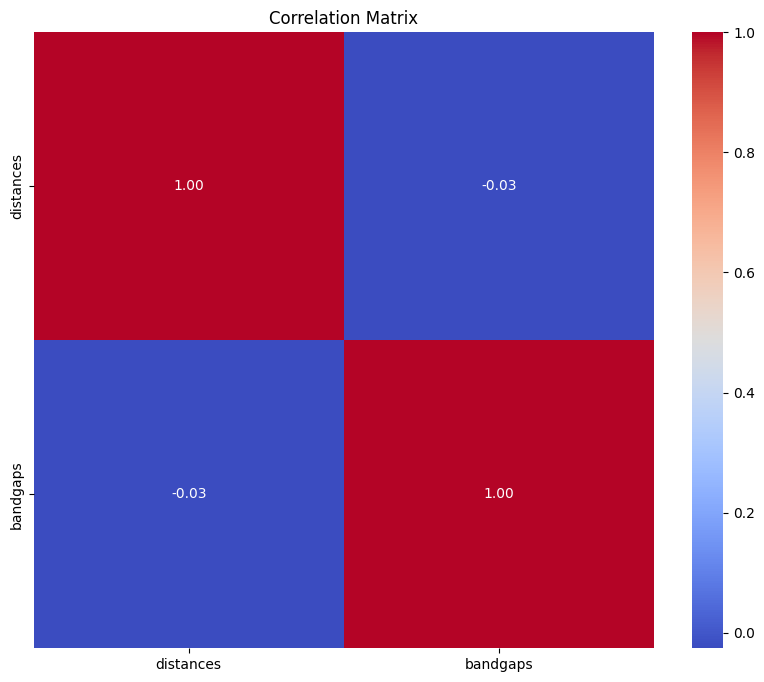

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

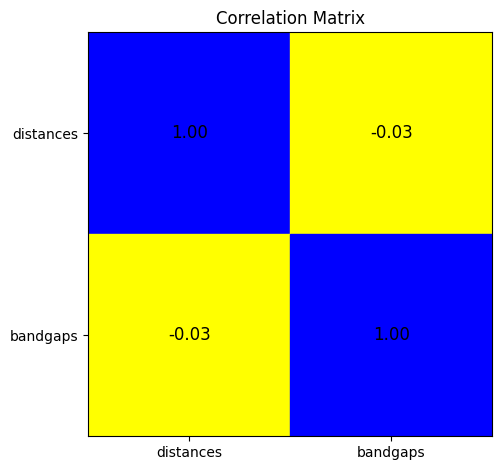

In [ ]:
# Compute correlation matrix
corr = df.corr()

# Extract values and labels
values = corr.values
labels = corr.columns.tolist()

# Create custom color matrix
colors = np.array([
    ['blue' if i == j else 'yellow' for j in range(2)]
    for i in range(2)
])

# Plot
fig, ax = plt.subplots()

for i in range(2):
    for j in range(2):
        ax.add_patch(plt.Rectangle((j, i), 1, 1, color=colors[i][j]))
        ax.text(j + 0.5, i + 0.5, f"{values[i, j]:.2f}",
                ha='center', va='center', color='black', fontsize=12)

# Axis formatting
ax.set_xlim(0, 2)
ax.set_ylim(0, 2)
ax.set_xticks([0.5, 1.5])
ax.set_yticks([0.5, 1.5])
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
ax.invert_yaxis()
ax.set_aspect('equal')
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()